#### Import Modules

In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import colabtools

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
# more common libraries for retrieving data
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import audioread
import json
import os
import itertools
from PIL import Image
import cv2

#### Preprocessing Functions

In [3]:
# return 3 self similarity matrices
def get_3ssm(audio_path):
    
    # load audio into np array
    y,sr = librosa.load(audio_path)

    # compute mfcc features and ssm
    hop_length = 1024
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length)
    ssm_mfcc = librosa.segment.recurrence_matrix(mfcc, metric='cosine', mode='affinity')

    #compute chroma features and ssm
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length = hop_length)
    ssm_chroma = librosa.segment.recurrence_matrix(chroma, metric='cosine', mode='affinity')

    #compute mel-spec features and ssm
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = hop_length)
    ssm_melspec = librosa.segment.recurrence_matrix(mel_spec, metric ='cosine', mode='affinity')

    return ssm_mfcc, ssm_chroma, ssm_melspec

# compress SSMs into png format
def ssm_to_png(mfcc, chroma, melspec, out_path):
    
    rgbArray = np.zeros((mfcc.shape[0],mfcc.shape[1],3), 'uint8')
    rgbArray[..., 0] = (mfcc/mfcc.max())*256
    rgbArray[..., 1] = (chroma/chroma.max())*256
    rgbArray[..., 2] = (melspec/melspec.max())*256
    img = Image.fromarray(rgbArray)
    img.save(out_path)
    
# return bounding box of chorus, verse, and intro labels of jams dataset    
def get_bbox(anno_path):
    
    # open file
    with open(anno_path) as a:
        data = json.load(a)    

    # check through all annotations and count segment labels    
    obj_list = []
    
    for annotation in data['annotations']:
        
        chorus = []
        verse = []
        intro = []
        segments = []

        for segment in annotation['data']:
            if segment['value'] == "chorus":
                chorus.append([segment['time'], segment["duration"]])
            elif segment['value'] == "verse":
                verse.append([segment['time'], segment["duration"]])
            elif segment['value'] == "intro":
                intro.append([segment['time'], segment["duration"]])

        segments.append(chorus)
        segments.append(verse)
        segments.append(intro)

        colors = ['r','g','b']
        c = 0
        for seglabels in segments:
            segcombos = itertools.product(seglabels, repeat=2)
            
            # get the segment combination bounding boxes
            for combo in segcombos:
                
                rect =  patches.Rectangle((combo[0][0], combo[1][0]), combo[0][1], combo[1][1], linewidth=1,edgecolor = colors[c], facecolor = 'none')
                bound = rect.get_bbox()
             
                px = np.arange(bound.x0, bound.x1, 1)
                py = np.arange(bound.y0, bound.y1, 1)

                poly = itertools.product(px, py)
                poly = np.array(list(poly))
                poly = np.hstack(poly)
                poly = (np.transpose(poly.reshape((np.shape(poly)[0],1)))).tolist()
                
                
                obj = {
                    "bbox": [bound.x0, bound.y0, bound.x1, bound.y1],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": poly,
                    "category_id": c,
                }
                obj_list.append(obj)
                
            c = c+1
    return obj_list

In [4]:
# return data in detectron dataset format
def get_audio_dicts(ds_dir):
    
    annos = ds_dir + '/references'
    audio = ds_dir + '/test'
    
    dataset_annos = []
    # Parse through available audio tags
    for file in os.listdir(audio):
        print(file)
        anno = annos + "/SALAMI_" + file.split(".")[0] + '.jams'
        if os.path.exists(anno):
            record = {}
            
            img = ds_dir + "/images/"+ file.split(".")[0] + '.png'
            if os.path.exists(img):
                record["file_name"] = img
            else:
                mfcc, chroma, melspec = get_3ssm(audio + '/' + file.split(".")[0] + '.wav')
                ssm_to_png(mfcc, chroma, melspec, img)
                record["file_name"] = img                
            
            record["image_id"] = int(file.split(".")[0])
            
            img = cv2.imread(img)
            dimensions = img.shape
            record["height"] = dimensions[0]
            record["width"] = dimensions[1]
        
            print('audio file: ' + file.split(".")[0])
            objs = get_bbox(anno)
            record["annotations"] = objs
            
        dataset_annos.append(record)
    return dataset_annos     

#### Register Catalog and Visualize Data

In [5]:
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
ds_dir = '/home/shared/cuzokwe/datasets/SALAMI'

In [6]:
# register dataset (and its metadata)
DatasetCatalog.register("salami_2020_img_test_set", get_audio_dicts)

In [7]:
# register dataset metadata (labels)
MetadataCatalog.get("salami_2020_img_test_set").thing_classes = ["chorus", "verse","intro"]

In [8]:
# unregister dataset
#DatasetCatalog.clear()

In [9]:
# show registered datasets
DatasetCatalog.list()

['coco_2014_train',
 'coco_2014_val',
 'coco_2014_minival',
 'coco_2014_minival_100',
 'coco_2014_valminusminival',
 'coco_2017_train',
 'coco_2017_val',
 'coco_2017_test',
 'coco_2017_test-dev',
 'coco_2017_val_100',
 'keypoints_coco_2014_train',
 'keypoints_coco_2014_val',
 'keypoints_coco_2014_minival',
 'keypoints_coco_2014_valminusminival',
 'keypoints_coco_2014_minival_100',
 'keypoints_coco_2017_train',
 'keypoints_coco_2017_val',
 'keypoints_coco_2017_val_100',
 'coco_2017_train_panoptic_separated',
 'coco_2017_train_panoptic_stuffonly',
 'coco_2017_val_panoptic_separated',
 'coco_2017_val_panoptic_stuffonly',
 'coco_2017_val_100_panoptic_separated',
 'coco_2017_val_100_panoptic_stuffonly',
 'lvis_v0.5_train',
 'lvis_v0.5_val',
 'lvis_v0.5_val_rand_100',
 'lvis_v0.5_test',
 'lvis_v0.5_train_cocofied',
 'lvis_v0.5_val_cocofied',
 'cityscapes_fine_instance_seg_train',
 'cityscapes_fine_sem_seg_train',
 'cityscapes_fine_instance_seg_val',
 'cityscapes_fine_sem_seg_val',
 'cityscap

In [16]:
wget -nc -q https://github.com/facebookresearch/detectron2/raw/master/detectron2/utils/collect_env.py

SyntaxError: invalid syntax (<ipython-input-16-bfa500c8fd04>, line 1)

In [10]:
dataset_dicts = get_audio_dicts(ds_dir)

2.wav
audio file: 2
3.wav
audio file: 3


(5958, 5958, 3)


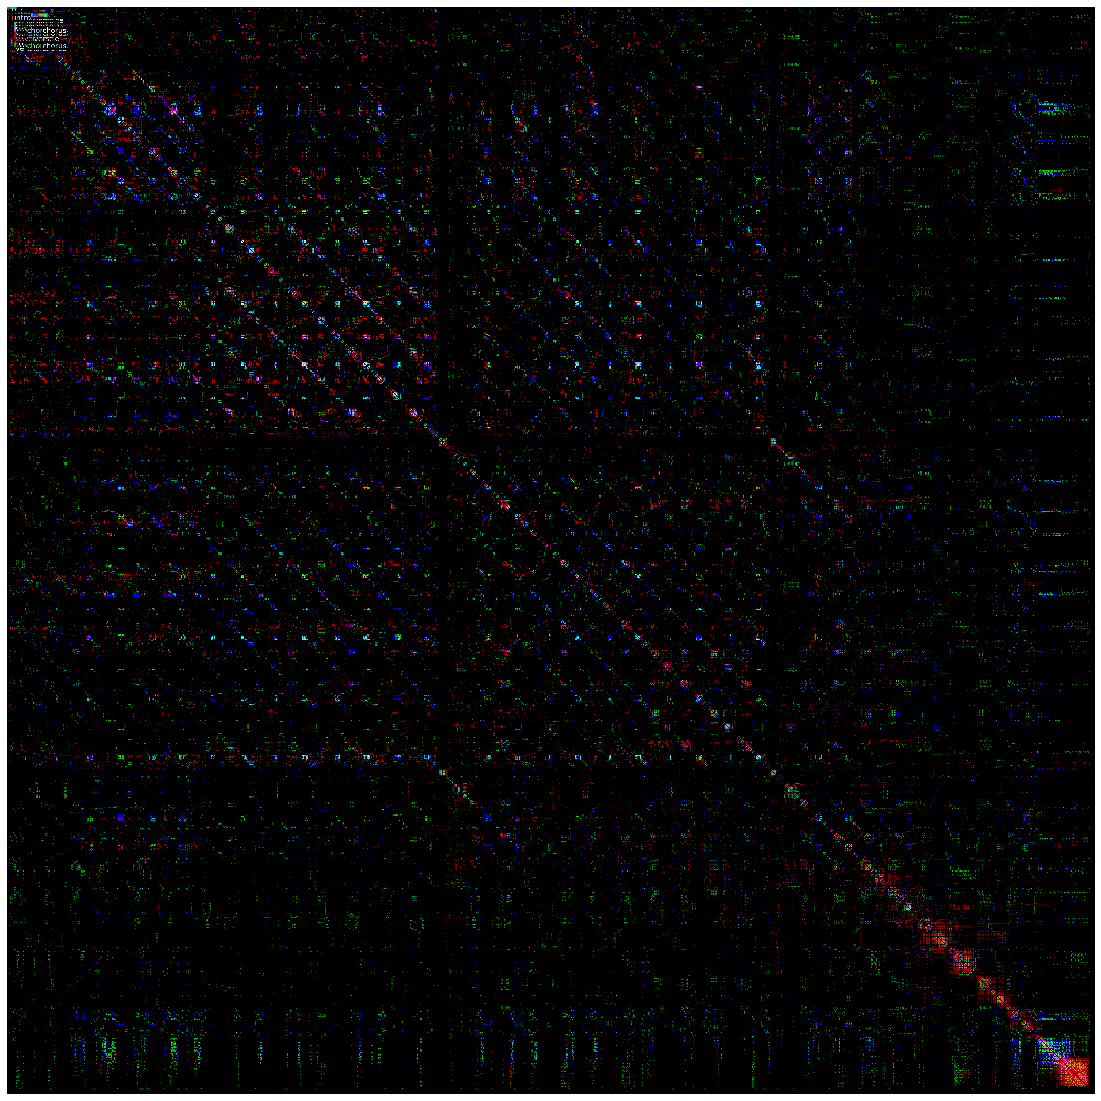

In [13]:
audio_metadata = MetadataCatalog.get("salami_2020_img_test_set")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    print(img.shape)
    visualizer = Visualizer(img[:, :, ::-1], metadata=audio_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,20))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()
    img = Image.fromarray(vis.get_image()[:, :, ::1])
    img.save('/home/shared/cuzokwe/datasets/SALAMI/test/datatest.png')
    #cv2_imshow(vis.get_image()[:, :, ::-1])


In [14]:
print(json.dumps(dataset_dicts[1], indent=2))

{
  "file_name": "/home/shared/cuzokwe/datasets/SALAMI/images/3.png",
  "image_id": 3,
  "height": 5958,
  "width": 5958,
  "annotations": [
    {
      "bbox": [
        109.646803,
        109.646803,
        117.382585,
        117.382585
      ],
      "bbox_mode": 0,
      "segmentation": [
        [
          109.646803,
          109.646803,
          109.646803,
          110.646803,
          109.646803,
          111.646803,
          109.646803,
          112.646803,
          109.646803,
          113.646803,
          109.646803,
          114.646803,
          109.646803,
          115.646803,
          109.646803,
          116.646803,
          110.646803,
          109.646803,
          110.646803,
          110.646803,
          110.646803,
          111.646803,
          110.646803,
          112.646803,
          110.646803,
          113.646803,
          110.646803,
          114.646803,
          110.646803,
          115.646803,
          110.646803,
          1